In [1]:
from skimage import io
import matplotlib.pyplot as plt
from skimage.transform import rescale
from data_utils import pnt_on_grid, quant_rot, background_map
import numpy as np
import pandas as pd
from data_mgmt import DAO
import tensorflow as tf
from IPython.display import clear_output

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)
from tensorflow.keras import layers, models, losses, backend, optimizers
#from tensorflow_addons.metrics import F1Score


1 Physical GPUs, 1 Logical GPUs


2022-06-01 14:48:11.448854: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-01 14:48:11.456326: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-01 14:48:11.456977: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-01 14:48:11.458803: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-01 14:48:11.459214: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [2]:
map_img = io.imread("data/map90.png")

map_img = map_img[:,:,0]

with open("data/datasetmymap_multirot.csv", "r") as data:
    laser_db = pd.read_csv(data, delimiter=";").copy()

Model definition

In [3]:
#coda separata (map_mask, rot_mask) 1.9M param
def model_define(map_img, laser, rot_dim=0, training=True):

    map_input = layers.Input(map_img.shape)
    
    map_branch_1 = layers.Conv2D(8, 11, padding="same", activation="relu", name="map_conv_1")(map_input)
    map_branch_2 = layers.Conv2D(16, 7, padding="same", activation="relu", name="map_conv_2")(map_branch_1)
    map_branch_3 = layers.MaxPool2D(5, strides=3, padding="same", name="map_pooling_1")(map_branch_2)
    map_branch_3 = layers.BatchNormalization()(map_branch_3)
    
    if training:
        map_branch_3 = layers.Dropout(0.3)(map_branch_3)
    else:
        map_branch_3 = layers.Dropout(0.0)(map_branch_3)
    
    map_branch_5 = layers.Conv2D(32, 7, padding="same", activation="relu", name="map_conv_3")(map_branch_3)
    map_branch_6 = layers.MaxPool2D(5, strides=3, padding="same", name="map_pooling_2")(map_branch_5)
    map_branch_6 = layers.BatchNormalization()(map_branch_6)
    
    if training:
        map_branch_6 = layers.Dropout(0.3)(map_branch_6)
    else:
        map_branch_6 = layers.Dropout(0.0)(map_branch_6)
    
    map_branch_8 = layers.Conv2D(64, 5, padding="same", activation="relu", name="map_conv_4")(map_branch_6)
    map_branch_9 = layers.MaxPool2D(3, strides=2, padding="same", name="map_pooling_3")(map_branch_8)
    map_branch_9 = layers.BatchNormalization()(map_branch_9)
    
    if training:
        map_branch_9 = layers.Dropout(0.3)(map_branch_9)
    else:
        map_branch_9 = layers.Dropout(0.0)(map_branch_9)
    
    map_branch_11 = layers.Conv2D(64, 5, padding="same", activation="relu", name="map_conv_5")(map_branch_9)
    map_branch_12 = layers.MaxPool2D(5, strides=3, padding="same", name="map_pooling_4")(map_branch_11)
    map_branch_12 = layers.BatchNormalization()(map_branch_12)

    if training:
        map_branch_12 = layers.Dropout(0.3)(map_branch_12)
    else:
        map_branch_12 = layers.Dropout(0.0)(map_branch_12)

    laser_input = layers.Input(laser.shape)

    laser_branch = layers.Conv1D(16, 11, padding="valid", activation="relu", name="laser_conv_1")(laser_input)
    laser_branch = layers.Conv1D(32, 7, padding="valid", activation="relu", name="laser_conv_2")(laser_branch)
    laser_branch = layers.MaxPool1D(5, strides=3, padding="same", name="laser_pool_1" )(laser_branch)
    laser_branch = layers.BatchNormalization()(laser_branch)
    
    if training:
        laser_branch = layers.Dropout(0.3)(laser_branch)
    else:
        laser_branch = layers.Dropout(0.0)(laser_branch)
    
    laser_branch = layers.Conv1D(64, kernel_size=5, padding="valid", activation="relu", name="laser_conv_3" )(laser_branch)
    laser_branch = layers.MaxPool1D(3, strides=2, padding="same", name="laser_pool_2" )(laser_branch)
    laser_branch = layers.BatchNormalization()(laser_branch)
    
    if training:
        laser_branch = layers.Dropout(0.3)(laser_branch)
    else:
        laser_branch = layers.Dropout(0.0)(laser_branch)

    laser_branch = layers.Conv1D(128, kernel_size=5, padding="valid", activation="relu", name="laser_conv_4" )(laser_branch)
    laser_branch = layers.MaxPool1D(3, strides=2, padding="same", name="laser_pool_3" )(laser_branch)
    laser_branch = layers.BatchNormalization()(laser_branch)


    laser_branch = layers.Flatten()(laser_branch)
    
    #merged_branch = layers.Concatenate()([map_branch_flat,laser_branch])

    if training:
        laser_branch = layers.Dropout(0.3)(laser_branch)
    else:
        laser_branch = layers.Dropout(0.0)(laser_branch)

    #in_model = models.Model([map_input,laser_input],merged_branch)

    #in_model.trainable = training

    laser_branch = layers.Dense((map_branch_12.shape[1]*map_branch_12.shape[2]*64), activation="relu", name="fc_merged")(laser_branch)
    laser_branch_reshape = layers.Reshape((map_branch_12.shape[1],map_branch_12.shape[2],64))(laser_branch)

    merged_branch_pos = layers.Concatenate()([map_branch_12,laser_branch_reshape])
    merged_branch_pos = layers.BatchNormalization()(merged_branch_pos)

    if training:
       merged_branch_pos = layers.Dropout(0.3)(merged_branch_pos)
    else:
        merged_branch_pos = layers.Dropout(0.0)(merged_branch_pos)

    merged_branch_pos_1 = layers.Conv2DTranspose(64,5,3, padding="same")(merged_branch_pos)

    #position branch
    
    diff_width = int(merged_branch_pos_1.shape[1] - map_branch_11.shape[1] + 1)
    diff_heigth = int(merged_branch_pos_1.shape[2] - map_branch_11.shape[2] + 1)

    padded = False

    if (diff_width > 1) or (diff_heigth > 1):
        padded = True

    if padded:
        merged_branch_pos = layers.Conv2D(32,(diff_width,diff_heigth),activation="relu", padding="valid")(merged_branch_pos_1)

    else:
        merged_branch_pos = layers.Conv2D(32,7,activation="relu", padding="same")(merged_branch_pos_1)

    merged_branch_pos = layers.BatchNormalization()(merged_branch_pos)

    merged_branch_pos = layers.Concatenate()([merged_branch_pos,map_branch_11])
   
    merged_branch_pos = layers.Conv2DTranspose(32,5,2, padding="same")(merged_branch_pos) 

    if training:
       merged_branch_pos = layers.Dropout(0.3)(merged_branch_pos)
    else:
        merged_branch_pos = layers.Dropout(0.0)(merged_branch_pos)

    diff_width = int(merged_branch_pos.shape[1] - map_branch_8.shape[1] + 1)
    diff_heigth = int(merged_branch_pos.shape[2] - map_branch_8.shape[2] + 1)

    padded = False

    if (diff_width > 1) or (diff_heigth > 1):
        padded = True

    if padded:
        merged_branch_pos = layers.Conv2D(16,(diff_width,diff_heigth),activation="relu", padding="valid")(merged_branch_pos)

    else:
        merged_branch_pos = layers.Conv2D(16,5,activation="relu", padding="same")(merged_branch_pos)

    merged_branch_pos = layers.BatchNormalization()(merged_branch_pos)

    merged_branch_pos = layers.Concatenate()([merged_branch_pos,map_branch_8])

    merged_branch_pos = layers.Conv2DTranspose(16,7,3, padding="same")(merged_branch_pos) 
    
    if training:
        merged_branch_pos = layers.Dropout(0.3)(merged_branch_pos)
    else:
        merged_branch_pos = layers.Dropout(0.0)(merged_branch_pos)

    diff_width = int(merged_branch_pos.shape[1] - map_branch_5.shape[1] + 1)
    diff_heigth = int(merged_branch_pos.shape[2] - map_branch_5.shape[2] + 1)

    padded = False

    if diff_width > 1 or diff_heigth > 1:
        padded = True

    if padded:
        merged_branch_pos = layers.Conv2D(8,(diff_width,diff_heigth),activation="relu", padding="valid")(merged_branch_pos)

    else:
        merged_branch_pos = layers.Conv2D(8,7,activation="relu", padding="same")(merged_branch_pos)
    
    merged_branch_pos = layers.BatchNormalization()(merged_branch_pos)

    merged_branch_pos = layers.Concatenate()([merged_branch_pos,map_branch_5])

    merged_branch_pos = layers.Conv2DTranspose(8,7,3, padding="same")(merged_branch_pos) 

    diff_width = int(merged_branch_pos.shape[1] - map_branch_2.shape[1] + 1)
    diff_heigth = int(merged_branch_pos.shape[2] - map_branch_2.shape[2] + 1)

    padded = False

    if diff_width > 1 or diff_heigth > 1:
        padded = True

    if padded:
        merged_branch_pos = layers.Conv2D(4,(diff_width,diff_heigth),activation="relu", padding="valid")(merged_branch_pos)

    else:
        merged_branch_pos = layers.Conv2D(4,7,activation="relu", padding="same")(merged_branch_pos)
    
    merged_branch_pos = layers.Concatenate()([merged_branch_pos,map_branch_2])

    merged_branch_pos = layers.Conv2DTranspose(2,11, padding="same", name="pos_output_conv")(merged_branch_pos)

    merged_branch_pos = layers.Dense(2, name="pos_output")(merged_branch_pos) 

    #rotation branch

    merged_branch_rot = layers.Conv2D(64,(merged_branch_pos_1.shape[1],1), activation="relu", padding="valid")(merged_branch_pos_1)

    if training:
        merged_branch_rot = layers.Dropout(0.3)(merged_branch_rot)
    else:
        merged_branch_rot = layers.Dropout(0.0)(merged_branch_rot)

    merged_branch_rot = layers.Reshape((merged_branch_pos_1.shape[2],64))(merged_branch_rot)

    merged_branch_rot = layers.Conv1DTranspose(32,5,3, activation="relu")(merged_branch_rot)

    diff_width = int(merged_branch_rot.shape[1] - int(rot_dim/9) + 1)
    padded = False

    if diff_width > 1:
        padded = True

    if padded:
        merged_branch_rot = layers.Conv1D(16,(diff_width,),activation="relu", padding="valid")(merged_branch_rot)

    else:
        merged_branch_rot = layers.Conv1D(16,7,activation="relu", padding="same")(merged_branch_rot)

    merged_branch_rot = layers.BatchNormalization()(merged_branch_rot)

    merged_branch_rot = layers.Conv1DTranspose(16,5,3, activation="relu")(merged_branch_rot)

    if training:
        merged_branch_rot = layers.Dropout(0.3)(merged_branch_rot)
    else:
        merged_branch_rot = layers.Dropout(0.0)(merged_branch_rot)

    diff_width = int(merged_branch_rot.shape[1] - int(rot_dim/3) + 1)
    padded = False

    if diff_width > 1:
        padded = True

    if padded:
        merged_branch_rot = layers.Conv1D(8,(diff_width,),activation="relu", padding="valid")(merged_branch_rot)

    else:
        merged_branch_rot = layers.Conv1D(8,7,activation="relu", padding="same")(merged_branch_rot)

    merged_branch_rot = layers.BatchNormalization()(merged_branch_rot)

    merged_branch_rot = layers.Conv1DTranspose(8,5,3, activation="relu")(merged_branch_rot)

    diff_width = int(merged_branch_rot.shape[1] - rot_dim + 1)
    padded = False

    if diff_width > 1:
        padded = True

    if padded:
        merged_branch_rot = layers.Conv1D(4,(diff_width,),activation="relu", padding="valid")(merged_branch_rot)

    else:
        merged_branch_rot = layers.Conv1D(4,7,activation="relu", padding="same")(merged_branch_rot)

    merged_branch_rot = layers.Conv1DTranspose(2, rot_dim, padding="same", name="rot_output_conv")(merged_branch_rot)

    merged_branch_rot = layers.Dense(2, name="rot_output")(merged_branch_rot)

    return models.Model([map_input,laser_input],[merged_branch_pos, merged_branch_rot])#merged_branch_pos)

beta = 0.2

def loss_pos_fn(y_true, y_pred):
    
    print("pos ",y_true)
    #print("rot ",y_true_rot)

    pos_loss = losses.SparseCategoricalCrossentropy(from_logits=True)(y_true, y_pred)
    #rot_loss = losses.MeanAbsoluteError()(y_true, y_pred)

    return pos_loss

def recall_pos(y_true, y_pred):
    y_pred = backend.argmax(y_pred,axis=-1)
    y_pred = backend.cast(backend.reshape(y_pred,[-1,y_pred.shape[1],y_pred.shape[2],1]),"float64")
    y_true = backend.cast(y_true,"float64")

    true_positives = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)))
    all_positives = backend.sum(backend.round(backend.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + backend.epsilon())
    return recall

def precision_pos(y_true, y_pred):
    y_pred = backend.argmax(y_pred,axis=-1)
    y_pred = backend.cast(backend.reshape(y_pred,[-1,y_pred.shape[1],y_pred.shape[2],1]),"float64")
    y_true = backend.cast(y_true,"float64")

    true_positives = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = backend.sum(backend.round(backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + backend.epsilon())
    return precision

def f1_score_pos(y_true, y_pred):
    precision_value = precision_pos(y_true, y_pred)
    recall_value = recall_pos(y_true, y_pred)
    return 2*((precision_value*recall_value)/(precision_value+recall_value+backend.epsilon()))

def recall_rot(y_true, y_pred):
    y_pred = backend.argmax(y_pred,axis=-1)
    y_pred = backend.cast(backend.reshape(y_pred,[-1,y_pred.shape[1],1]),"float64")
    y_true = backend.cast(y_true,"float64")

    true_positives = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)))
    all_positives = backend.sum(backend.round(backend.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + backend.epsilon())
    return recall

def precision_rot(y_true, y_pred):
    y_pred = backend.argmax(y_pred,axis=-1)
    y_pred = backend.cast(backend.reshape(y_pred,[-1,y_pred.shape[1],1]),"float64")
    y_true = backend.cast(y_true,"float64")

    true_positives = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = backend.sum(backend.round(backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + backend.epsilon())
    return precision

def f1_score_rot(y_true, y_pred):
    precision_value = precision_rot(y_true, y_pred)
    recall_value = recall_rot(y_true, y_pred)
    return 2*((precision_value*recall_value)/(precision_value+recall_value+backend.epsilon()))


In [3]:
#coda separata (map_mask, rot_mask)
def model_define(map_img, laser, rot_dim=0, training=True):

    map_input = layers.Input(map_img.shape)
    
    map_branch_1 = layers.Conv2D(8, 11, padding="same", activation="relu", name="map_conv_1")(map_input)
    map_branch_2 = layers.Conv2D(16, 7, padding="same", activation="relu", name="map_conv_2")(map_branch_1)
    map_branch_3 = layers.MaxPool2D(5, strides=3, padding="same", name="map_pooling_1")(map_branch_2)
    map_branch_3 = layers.BatchNormalization()(map_branch_3)
    
    if training:
        map_branch_3 = layers.Dropout(0.3)(map_branch_3)
    else:
        map_branch_3 = layers.Dropout(0.0)(map_branch_3)
    
    map_branch_5 = layers.Conv2D(32, 7, padding="same", activation="relu", name="map_conv_3")(map_branch_3)
    map_branch_6 = layers.MaxPool2D(5, strides=3, padding="same", name="map_pooling_2")(map_branch_5)
    map_branch_6 = layers.BatchNormalization()(map_branch_6)
    
    if training:
        map_branch_6 = layers.Dropout(0.3)(map_branch_6)
    else:
        map_branch_6 = layers.Dropout(0.0)(map_branch_6)
    
    map_branch_8 = layers.Conv2D(64, 5, padding="same", activation="relu", name="map_conv_4")(map_branch_6)
    map_branch_9 = layers.MaxPool2D(3, strides=2, padding="same", name="map_pooling_3")(map_branch_8)
    map_branch_9 = layers.BatchNormalization()(map_branch_9)
    
    if training:
        map_branch_9 = layers.Dropout(0.3)(map_branch_9)
    else:
        map_branch_9 = layers.Dropout(0.0)(map_branch_9)
    
    map_branch_11 = layers.Conv2D(64, 5, padding="same", activation="relu", name="map_conv_5")(map_branch_9)
    map_branch_12 = layers.MaxPool2D(5, strides=3, padding="same", name="map_pooling_4")(map_branch_11)
    map_branch_12 = layers.BatchNormalization()(map_branch_12)

    if training:
        map_branch_12 = layers.Dropout(0.3)(map_branch_12)
    else:
        map_branch_12 = layers.Dropout(0.0)(map_branch_12)

    laser_input = layers.Input(laser.shape)

    laser_branch = layers.Conv1D(16, 11, padding="valid", activation="relu", name="laser_conv_1")(laser_input)
    laser_branch = layers.Conv1D(32, 7, padding="valid", activation="relu", name="laser_conv_2")(laser_branch)
    laser_branch = layers.MaxPool1D(5, strides=3, padding="same", name="laser_pool_1" )(laser_branch)
    laser_branch = layers.BatchNormalization()(laser_branch)
    
    if training:
        laser_branch = layers.Dropout(0.3)(laser_branch)
    else:
        laser_branch = layers.Dropout(0.0)(laser_branch)
    
    laser_branch = layers.Conv1D(64, kernel_size=5, padding="valid", activation="relu", name="laser_conv_3" )(laser_branch)
    laser_branch = layers.MaxPool1D(3, strides=2, padding="same", name="laser_pool_2" )(laser_branch)
    laser_branch = layers.BatchNormalization()(laser_branch)
    
    if training:
        laser_branch = layers.Dropout(0.3)(laser_branch)
    else:
        laser_branch = layers.Dropout(0.0)(laser_branch)

    laser_branch = layers.Conv1D(128, kernel_size=5, padding="valid", activation="relu", name="laser_conv_4" )(laser_branch)
    laser_branch = layers.MaxPool1D(3, strides=2, padding="same", name="laser_pool_3" )(laser_branch)
    laser_branch = layers.BatchNormalization()(laser_branch)


    laser_branch = layers.Flatten()(laser_branch)
    
    #merged_branch = layers.Concatenate()([map_branch_flat,laser_branch])

    if training:
        laser_branch = layers.Dropout(0.3)(laser_branch)
    else:
        laser_branch = layers.Dropout(0.0)(laser_branch)

    #in_model = models.Model([map_input,laser_input],merged_branch)

    #in_model.trainable = training

    laser_branch = layers.Dense((map_branch_12.shape[1]*map_branch_12.shape[2]*64), activation="relu", name="fc_merged")(laser_branch)
    laser_branch_reshape = layers.Reshape((map_branch_12.shape[1],map_branch_12.shape[2],64))(laser_branch)

    merged_branch_pos = layers.Concatenate()([map_branch_12,laser_branch_reshape])
    merged_branch_pos = layers.BatchNormalization()(merged_branch_pos)

    if training:
       merged_branch_pos = layers.Dropout(0.3)(merged_branch_pos)
    else:
        merged_branch_pos = layers.Dropout(0.0)(merged_branch_pos)

    merged_branch_pos_1 = layers.Conv2DTranspose(64,5,3, padding="same")(merged_branch_pos)

    #position branch
    
    diff_width = int(merged_branch_pos_1.shape[1] - map_branch_11.shape[1] + 1)
    diff_heigth = int(merged_branch_pos_1.shape[2] - map_branch_11.shape[2] + 1)

    padded = False

    if (diff_width > 1) or (diff_heigth > 1):
        padded = True

    if padded:
        merged_branch_pos = layers.Conv2D(32,(diff_width,diff_heigth),activation="relu", padding="valid")(merged_branch_pos_1)

    else:
        merged_branch_pos = layers.Conv2D(32,7,activation="relu", padding="same")(merged_branch_pos_1)

    merged_branch_pos = layers.BatchNormalization()(merged_branch_pos)

    merged_branch_pos = layers.Concatenate()([merged_branch_pos,map_branch_11])
   
    merged_branch_pos = layers.Conv2DTranspose(32,5,2, padding="same")(merged_branch_pos) 

    if training:
       merged_branch_pos = layers.Dropout(0.3)(merged_branch_pos)
    else:
        merged_branch_pos = layers.Dropout(0.0)(merged_branch_pos)

    merged_branch_pos = layers.BatchNormalization()(merged_branch_pos)

    diff_width = int(merged_branch_pos.shape[1] - map_branch_8.shape[1] + 1)
    diff_heigth = int(merged_branch_pos.shape[2] - map_branch_8.shape[2] + 1)

    padded = False

    if (diff_width > 1) or (diff_heigth > 1):
        padded = True

    if padded:
        merged_branch_pos = layers.Conv2D(16,(diff_width,diff_heigth),activation="relu", padding="valid")(merged_branch_pos)

    else:
        merged_branch_pos = layers.Conv2D(16,5,activation="relu", padding="same")(merged_branch_pos)

    merged_branch_pos = layers.BatchNormalization()(merged_branch_pos)

    merged_branch_pos = layers.Concatenate()([merged_branch_pos,map_branch_8])

    merged_branch_pos = layers.Conv2DTranspose(16,7,3, padding="same")(merged_branch_pos) 
    
    if training:
        merged_branch_pos = layers.Dropout(0.3)(merged_branch_pos)
    else:
        merged_branch_pos = layers.Dropout(0.0)(merged_branch_pos)

    merged_branch_pos = layers.BatchNormalization()(merged_branch_pos)

    diff_width = int(merged_branch_pos.shape[1] - map_branch_5.shape[1] + 1)
    diff_heigth = int(merged_branch_pos.shape[2] - map_branch_5.shape[2] + 1)

    padded = False

    if diff_width > 1 or diff_heigth > 1:
        padded = True

    if padded:
        merged_branch_pos = layers.Conv2D(8,(diff_width,diff_heigth),activation="relu", padding="valid")(merged_branch_pos)

    else:
        merged_branch_pos = layers.Conv2D(8,7,activation="relu", padding="same")(merged_branch_pos)
    
    merged_branch_pos = layers.BatchNormalization()(merged_branch_pos)

    merged_branch_pos = layers.Concatenate()([merged_branch_pos,map_branch_5])

    merged_branch_pos = layers.Conv2DTranspose(8,7,3, padding="same")(merged_branch_pos) 

    if training:
        merged_branch_pos = layers.Dropout(0.3)(merged_branch_pos)
    else:
        merged_branch_pos = layers.Dropout(0.0)(merged_branch_pos)

    merged_branch_pos = layers.BatchNormalization()(merged_branch_pos)

    diff_width = int(merged_branch_pos.shape[1] - map_branch_2.shape[1] + 1)
    diff_heigth = int(merged_branch_pos.shape[2] - map_branch_2.shape[2] + 1)

    padded = False

    if diff_width > 1 or diff_heigth > 1:
        padded = True

    if padded:
        merged_branch_pos = layers.Conv2D(4,(diff_width,diff_heigth),activation="relu", padding="valid")(merged_branch_pos)

    else:
        merged_branch_pos = layers.Conv2D(4,7,activation="relu", padding="same")(merged_branch_pos)
    
    merged_branch_pos = layers.BatchNormalization()(merged_branch_pos)

    merged_branch_pos = layers.Concatenate()([merged_branch_pos,map_branch_2])

    merged_branch_pos = layers.Conv2DTranspose(2,11, padding="same", name="pos_output")(merged_branch_pos)

    #rotation branch

    merged_branch_rot = layers.Conv2D(64,(merged_branch_pos_1.shape[1],1), activation="relu", padding="valid")(merged_branch_pos_1)

    if training:
        merged_branch_rot = layers.Dropout(0.3)(merged_branch_rot)
    else:
        merged_branch_rot = layers.Dropout(0.0)(merged_branch_rot)

    merged_branch_rot = layers.Reshape((merged_branch_pos_1.shape[2],64))(merged_branch_rot)

    merged_branch_rot = layers.Conv1DTranspose(32,5,3, activation="relu")(merged_branch_rot)

    diff_width = int(merged_branch_rot.shape[1] - int(rot_dim/9) + 1)
    padded = False

    if diff_width > 1:
        padded = True

    if padded:
        merged_branch_rot = layers.Conv1D(16,(diff_width,),activation="relu", padding="valid")(merged_branch_rot)

    else:
        merged_branch_rot = layers.Conv1D(16,7,activation="relu", padding="same")(merged_branch_rot)

    merged_branch_rot = layers.BatchNormalization()(merged_branch_rot)

    merged_branch_rot = layers.Conv1DTranspose(16,5,3, activation="relu")(merged_branch_rot)

    if training:
        merged_branch_rot = layers.Dropout(0.3)(merged_branch_rot)
    else:
        merged_branch_rot = layers.Dropout(0.0)(merged_branch_rot)

    merged_branch_rot = layers.BatchNormalization()(merged_branch_rot)

    diff_width = int(merged_branch_rot.shape[1] - int(rot_dim/3) + 1)
    padded = False

    if diff_width > 1:
        padded = True

    if padded:
        merged_branch_rot = layers.Conv1D(8,(diff_width,),activation="relu", padding="valid")(merged_branch_rot)

    else:
        merged_branch_rot = layers.Conv1D(8,7,activation="relu", padding="same")(merged_branch_rot)

    merged_branch_rot = layers.BatchNormalization()(merged_branch_rot)

    merged_branch_rot = layers.Conv1DTranspose(8,5,3, activation="relu")(merged_branch_rot)

    if training:
        merged_branch_rot = layers.Dropout(0.3)(merged_branch_rot)
    else:
        merged_branch_rot = layers.Dropout(0.0)(merged_branch_rot)

    merged_branch_rot = layers.BatchNormalization()(merged_branch_rot)

    diff_width = int(merged_branch_rot.shape[1] - rot_dim + 1)
    padded = False

    if diff_width > 1:
        padded = True

    if padded:
        merged_branch_rot = layers.Conv1D(4,(diff_width,),activation="relu", padding="valid")(merged_branch_rot)

    else:
        merged_branch_rot = layers.Conv1D(4,7,activation="relu", padding="same")(merged_branch_rot)

    merged_branch_rot = layers.Conv1DTranspose(2, rot_dim, padding="same", name="rot_output")(merged_branch_rot)

    return models.Model([map_input,laser_input],[merged_branch_pos, merged_branch_rot])#merged_branch_pos)

beta = 0.2

def loss_pos_fn(y_true, y_pred):
    
    print("pos ",y_true)
    #print("rot ",y_true_rot)

    pos_loss = losses.SparseCategoricalCrossentropy(from_logits=True)(y_true, y_pred)
    #rot_loss = losses.MeanAbsoluteError()(y_true, y_pred)

    return pos_loss

def recall_pos(y_true, y_pred):
    y_pred = backend.argmax(y_pred,axis=-1)
    y_pred = backend.cast(backend.reshape(y_pred,[-1,y_pred.shape[1],y_pred.shape[2],1]),"float64")
    y_true = backend.cast(y_true,"float64")

    true_positives = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)))
    all_positives = backend.sum(backend.round(backend.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + backend.epsilon())
    return recall

def precision_pos(y_true, y_pred):
    y_pred = backend.argmax(y_pred,axis=-1)
    y_pred = backend.cast(backend.reshape(y_pred,[-1,y_pred.shape[1],y_pred.shape[2],1]),"float64")
    y_true = backend.cast(y_true,"float64")

    true_positives = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = backend.sum(backend.round(backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + backend.epsilon())
    return precision

def f1_score_pos(y_true, y_pred):
    precision_value = precision_pos(y_true, y_pred)
    recall_value = recall_pos(y_true, y_pred)
    return 2*((precision_value*recall_value)/(precision_value+recall_value+backend.epsilon()))

def recall_rot(y_true, y_pred):
    y_pred = backend.argmax(y_pred,axis=-1)
    y_pred = backend.cast(backend.reshape(y_pred,[-1,y_pred.shape[1],1]),"float64")
    y_true = backend.cast(y_true,"float64")

    true_positives = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)))
    all_positives = backend.sum(backend.round(backend.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + backend.epsilon())
    return recall

def precision_rot(y_true, y_pred):
    y_pred = backend.argmax(y_pred,axis=-1)
    y_pred = backend.cast(backend.reshape(y_pred,[-1,y_pred.shape[1],1]),"float64")
    y_true = backend.cast(y_true,"float64")

    true_positives = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = backend.sum(backend.round(backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + backend.epsilon())
    return precision

def f1_score_rot(y_true, y_pred):
    precision_value = precision_rot(y_true, y_pred)
    recall_value = recall_rot(y_true, y_pred)
    return 2*((precision_value*recall_value)/(precision_value+recall_value+backend.epsilon()))


In [4]:
laser_inst=[]

for i in laser_db.values:
    if i[0] == 1:
        laser_inst.append(i[3])

laser_inst = tf.reshape(laser_inst, [360,1])

pixel_scale = 0.05
tot_pixel = map_img.shape[0]*map_img.shape[1]

if tot_pixel > 10000:
    rate_rescale = np.sqrt(10000/tot_pixel)
    map_img = rescale(map_img,rate_rescale)
    pixel_scale = pixel_scale/rate_rescale

map_img_tensor = tf.reshape(map_img, [map_img.shape[0],map_img.shape[1],1])

In [5]:
model = model_define(map_img_tensor, laser_inst,90)

In [6]:
model.load_weights("models/cp-epoch-train.ckpt")

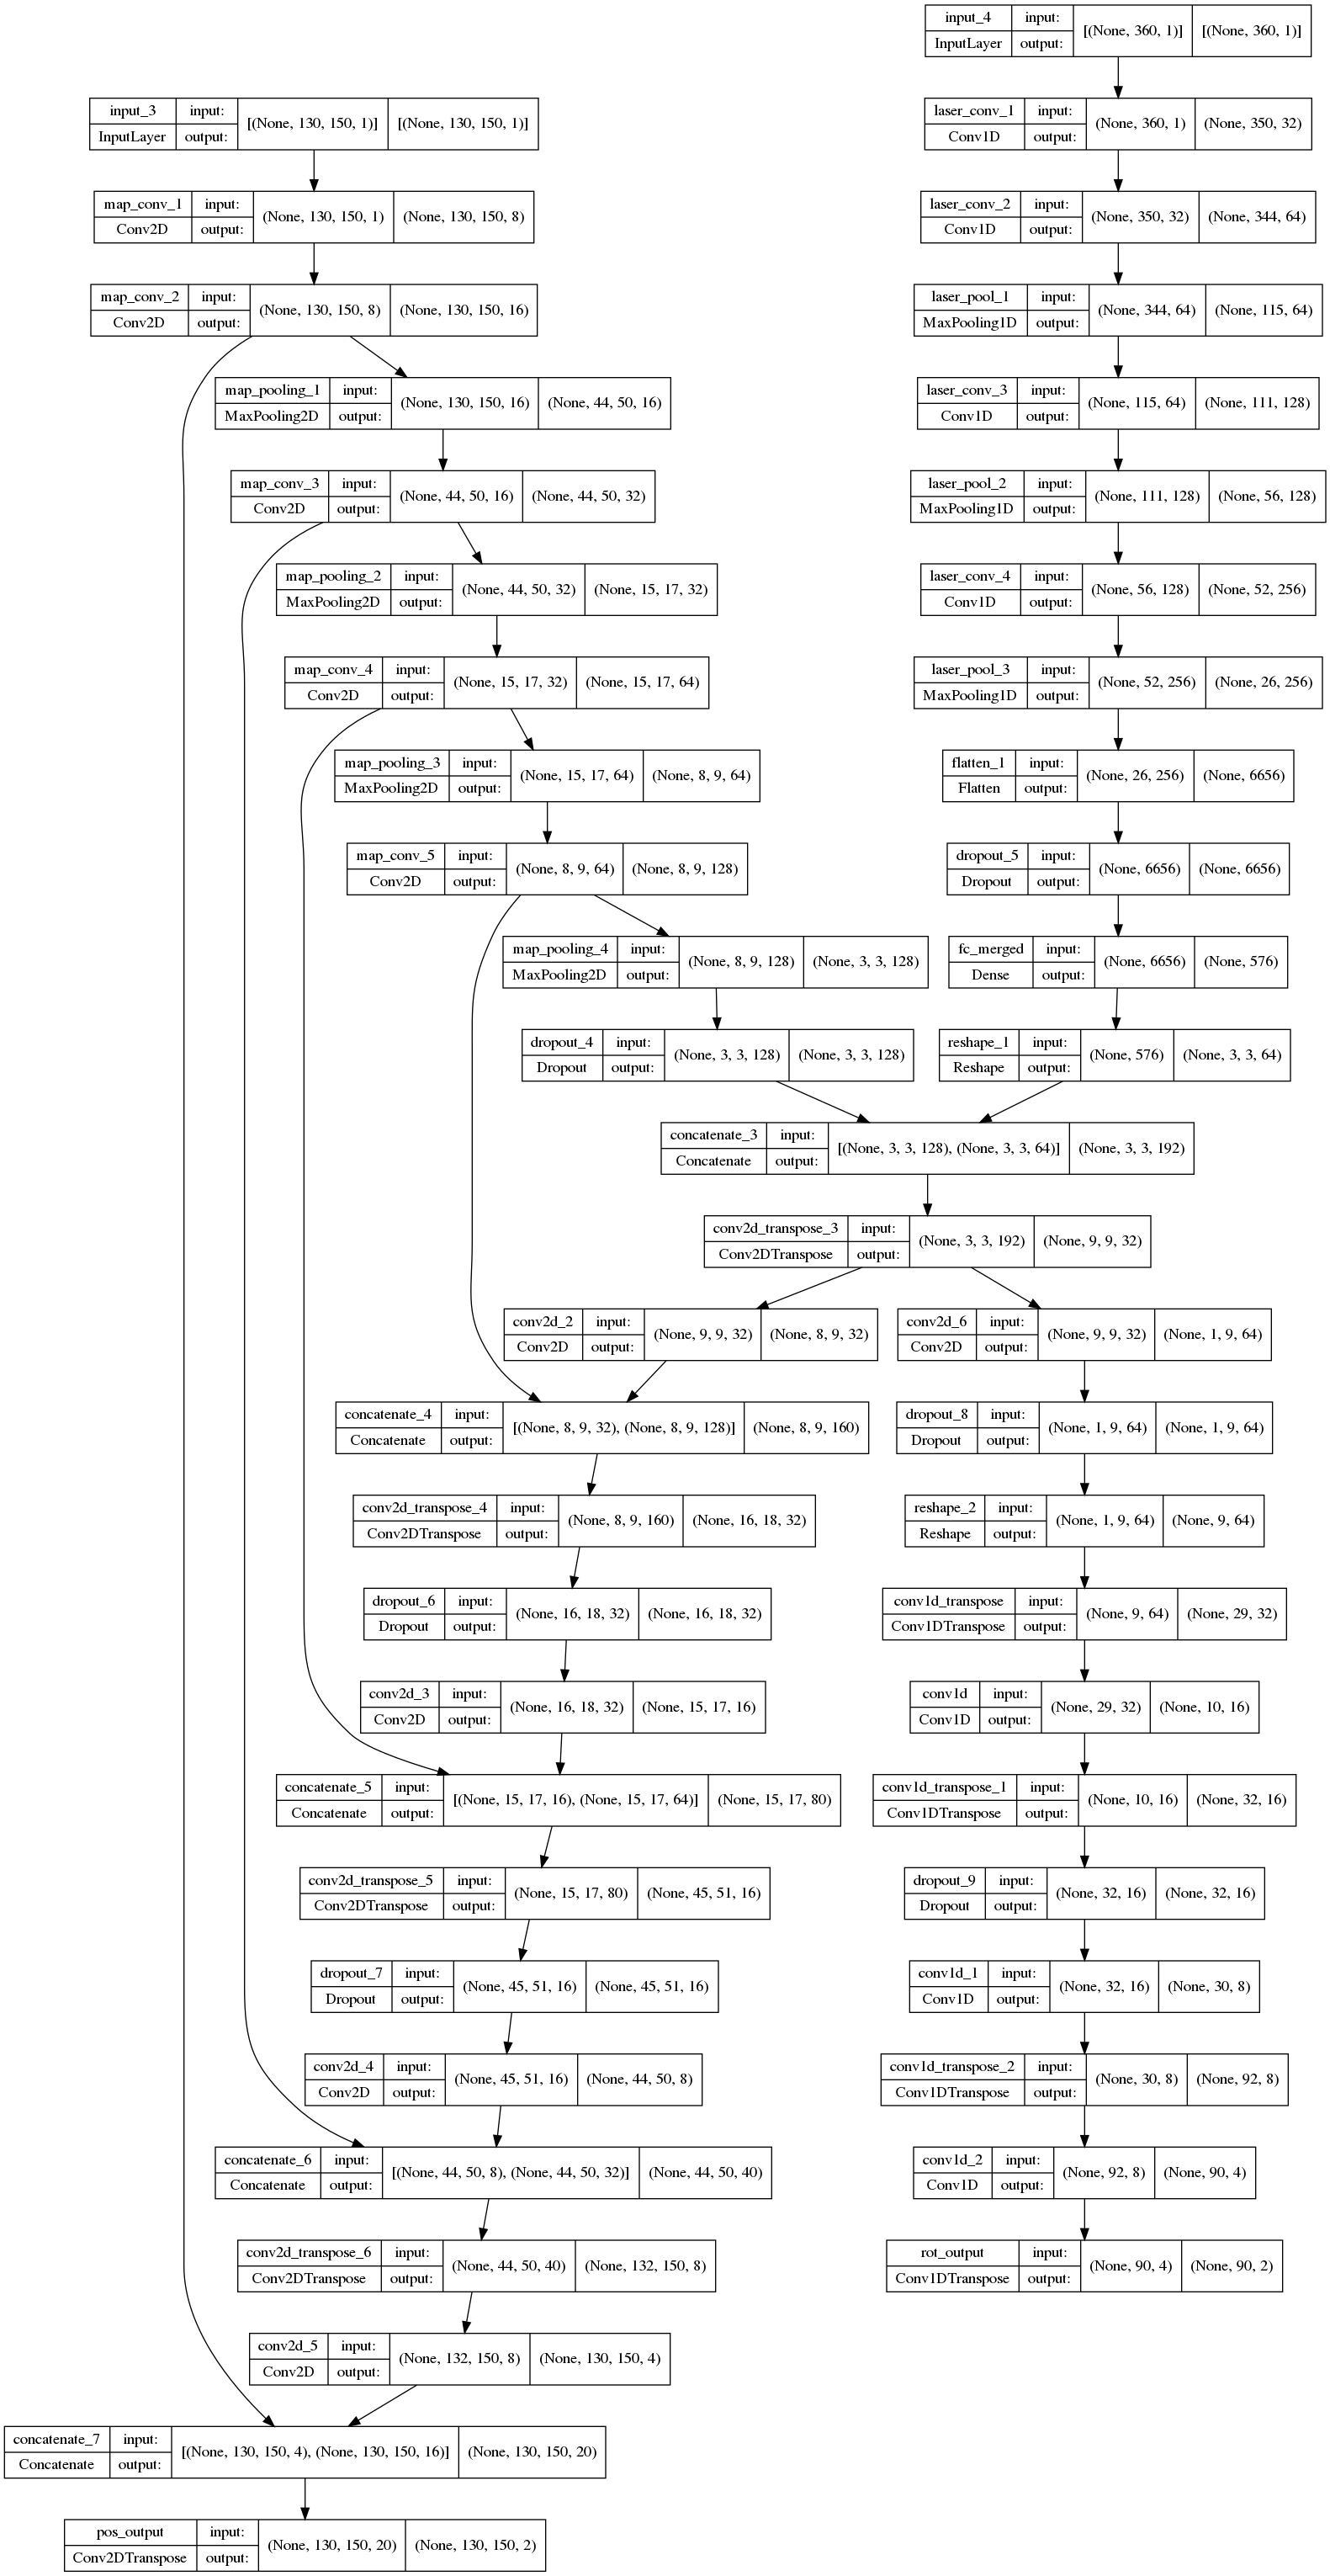

In [12]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 82, 122, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 map_conv_1 (Conv2D)            (None, 82, 122, 8)   976         ['input_3[0][0]']                
                                                                                                  
 input_4 (InputLayer)           [(None, 360, 1)]     0           []                               
                                                                                                  
 map_conv_2 (Conv2D)            (None, 82, 122, 16)  6288        ['map_conv_1[0][0]']         

In [7]:
model.compile(optimizer = optimizers.Adam(),
    loss=[losses.SparseCategoricalCrossentropy(from_logits=True),losses.SparseCategoricalCrossentropy(from_logits=True)],#losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[[f1_score_pos],[f1_score_rot]]    #["accuracy"]
    )

Data import

In [10]:
data = DAO("datasetmap90_multirot.csv")
data.read()
data.divide_data()

In [11]:
data.TR_features=tf.reshape(data.TR_features,[-1,360,1])
data.TS_features=tf.reshape(data.TS_features,[-1,360,1])
data.TR_targets=tf.reshape(data.TR_targets,[-1,3])
data.TS_targets=tf.reshape(data.TS_targets,[-1,3])

data.TR_targets_pos=tf.gather(data.TR_targets,[0,1],axis=1)
data.TS_targets_pos=tf.gather(data.TS_targets,[0,1],axis=1)
data.TR_targets_rot=tf.gather(data.TR_targets,[2],axis=1)
data.TS_targets_rot=tf.gather(data.TS_targets,[2],axis=1)

In [12]:
TR_map=[]
TS_map=[]

for i in range(data.TR_features.shape[0]):
    TR_map.append(map_img_tensor)

for i in range(data.TS_features.shape[0]):
    TS_map.append(map_img_tensor)

TR_map = tf.reshape(TR_map,[-1,map_img_tensor.shape[0],map_img_tensor.shape[1]])
TS_map = tf.reshape(TS_map,[-1,map_img_tensor.shape[0],map_img_tensor.shape[1]])

In [13]:
#position grid

TR_masks = []

for i in data.TR_targets_pos.numpy():
    map_grid_inst = pnt_on_grid(map_img, i,5,pixel_scale)
    TR_masks.append(map_grid_inst)

TS_masks = []

for i in data.TS_targets_pos.numpy():
    map_grid_inst = pnt_on_grid(map_img, i,5,pixel_scale)
    TS_masks.append(map_grid_inst)

#rotation grid

TR_masks_rot = []

for i in data.TR_targets_rot.numpy():
    rot_grid_inst = quant_rot(i,90, 3)
    TR_masks_rot.append(rot_grid_inst)

TS_masks_rot = []

for i in data.TS_targets_rot.numpy():
    rot_grid_inst = quant_rot(i,90, 3)
    TS_masks_rot.append(rot_grid_inst)



In [24]:
with open('data/temp/TR_masks.csv', 'w') as f:
    cnt=1

    for map_grid_inst in TR_masks:
        
        n_item = 0

        f.write("{};".format(cnt))
        for row in map_grid_inst:
            for item in row:
                if n_item == len(row)*len(map_grid_inst)-1:
                    f.write("{}".format(item))                 
                else:
                    f.write("{};".format(item))
                n_item += 1
        
        cnt += 1
        f.write("\n")

with open('data/temp/TS_masks.csv', 'w') as f:
    cnt=1

    for map_grid_inst in TS_masks:
        
        n_item = 0

        f.write("{};".format(cnt))
        for row in map_grid_inst:
            for item in row:
                if n_item == len(row)*len(map_grid_inst)-1:
                    f.write("{}".format(item))                 
                else:
                    f.write("{};".format(item))
                n_item += 1
        
        cnt += 1
        f.write("\n")

In [25]:
with open('data/temp/TR_mask_rot.csv', 'w') as f:
    cnt=1

    for rot_grid_inst in TR_masks_rot:
        
        n_item = 0

        f.write("{};".format(cnt))
        for item in rot_grid_inst:
        
            if n_item == len(rot_grid_inst)-1:
                f.write("{}".format(item))                 
            else:
                f.write("{};".format(item))
            n_item += 1
        
        cnt += 1
        f.write("\n")

with open('data/temp/TS_mask_rot.csv', 'w') as f:
    cnt=1

    for rot_grid_inst in TS_masks_rot:
        
        n_item = 0

        f.write("{};".format(cnt))
        for item in rot_grid_inst:
        
            if n_item == len(rot_grid_inst)-1:
                f.write("{}".format(item))                 
            else:
                f.write("{};".format(item))
            n_item += 1
        
        cnt += 1
        f.write("\n")

In [10]:
from sklearn.model_selection import train_test_split

with open("data/datasetmymap_multirot2_gridpos_r7.csv", "r") as file:
    laser_db_mask = pd.read_csv(file, delimiter=";",header=None).copy()

masks = laser_db_mask.drop(columns=[0])

if len(masks.values) > 3600:
    masks = masks.head(3601)

TR_x, TS_x, TR_masks, TS_masks = train_test_split(data.features, masks, test_size= 0.25, random_state= 42)

with open("data/datasetmymap_multirot2_gridrot_r3_q90.csv", "r") as file:
    laser_db_mask_rot = pd.read_csv(file, delimiter=";",header=None).copy()

masks_rot = laser_db_mask_rot.drop(columns=[0])

if len(masks_rot.values) > 3600:
    masks_rot = masks_rot.head(3601)

TR_x, TS_x, TR_masks_rot, TS_masks_rot = train_test_split(data.features, masks_rot, test_size= 0.25, random_state= 42)

In [ ]:
with open("data/temp/TR_masks.csv", "r") as file:
    TR_masks = pd.read_csv(file, delimiter=";",header=None).copy()

with open("data/temp/TS_masks.csv", "r") as file:
    TS_masks = pd.read_csv(file, delimiter=";",header=None).copy()

with open("data/temp/TR_mask_rot.csv", "r") as file:
    TR_masks_rot = pd.read_csv(file, delimiter=";",header=None).copy()

with open("data/temp/TS_mask_rot.csv", "r") as file:
    TS_masks_rot = pd.read_csv(file, delimiter=";",header=None).copy()

TR_masks = TR_masks.drop(columns=[0])
TS_masks = TS_masks.drop(columns=[0])
TR_masks_rot = TR_masks_rot.drop(columns=[0])
TS_masks_rot = TS_masks_rot.drop(columns=[0])


In [14]:
TR_masks = tf.reshape(TR_masks,[-1,map_img_tensor.shape[0],map_img_tensor.shape[1],1])
TS_masks = tf.reshape(TS_masks,[-1,map_img_tensor.shape[0],map_img_tensor.shape[1],1])

TR_masks_rot = tf.reshape(TR_masks_rot,[-1,90,1])
TS_masks_rot = tf.reshape(TS_masks_rot,[-1,90,1])

2022-06-01 12:04:28.615586: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 312124800 exceeds 10% of free system memory.


Model Training

In [23]:
test_map = TS_map[0]
#test_x = TS_x.values[0]
test_x = data.TS_features.numpy()[0]

test_map = tf.reshape(test_map,[1,map_img_tensor.shape[0],map_img_tensor.shape[1],1])
test_x = tf.reshape(test_x,[1,360])

pred_test_pos,pred_test_rot = model.predict([test_map,test_x])
sample = create_mask(pred_test_pos)
sample_rot = create_mask(pred_test_rot)

#pred_test = model.predict([test_map,test_x])
#sample = create_mask(pred_test)

sample_targets = data.TS_targets_pos[0]

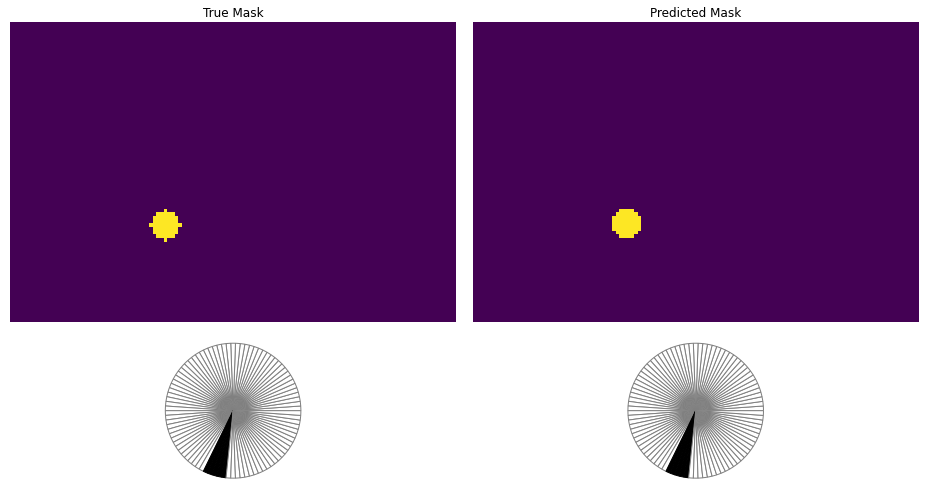

In [43]:
display([TS_masks[0],sample],[TS_masks_rot[0],sample_rot])

In [16]:

class MyCallback(tf.keras.callbacks.Callback):
    min_loss=0

    test_map = TS_map[0]
    test_x = data.TS_features[0]

    test_map = tf.reshape(test_map,[1,map_img_tensor.shape[0],map_img_tensor.shape[1],1])
    test_x = tf.reshape(test_x,[1,360])

    def on_epoch_end(self, epoch, logs=False):
        
        met_value = (logs["val_pos_output_f1_score_pos"] + logs["val_rot_output_f1_score_rot"])/5 - np.log10((logs["val_loss"]*5))

        if met_value >self.min_loss:
            model.save_weights("models/cp-epoch-train.ckpt")
            self.min_loss = met_value
        
        #if epoch % 5 == 4:
            clear_output(wait=True)
            print(met_value)
            pred_output = model.predict([self.test_map,self.test_x])
            display([TS_masks[0],create_mask(pred_output[0])],[TS_masks_rot[0],create_mask(pred_output[1])])#)])

my_callback= MyCallback()

In [ ]:
history = model.fit([TR_map,data.TR_features],
    data.TR_targets_pos,#[data.TR_targets_pos, data.TR_targets_rot], 
    validation_data=([TS_map,data.TS_features],data.TS_targets_pos),#[data.TS_targets_pos,data.TS_targets_rot]), 
    verbose=1,
    batch_size=16,
    epochs=50,
    callbacks=[my_callback]
    )

1.1690246619293307


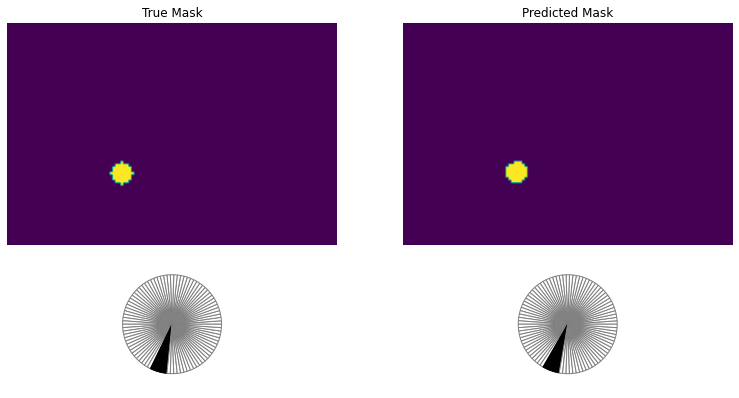

244/244 [==============================] - 18s 72ms/step - loss: 0.0222 - pos_output_loss: 0.0052 - rot_output_loss: 0.0170 - pos_output_f1_score_pos: 0.7710 - rot_output_f1_score_rot: 0.9367 - val_loss: 0.0297 - val_pos_output_loss: 0.0054 - val_rot_output_loss: 0.0243 - val_pos_output_f1_score_pos: 0.7861 - val_rot_output_f1_score_rot: 0.9181
Epoch 192/200
244/244 [==============================] - 16s 67ms/step - loss: 0.0220 - pos_output_loss: 0.0052 - rot_output_loss: 0.0168 - pos_output_f1_score_pos: 0.7732 - rot_output_f1_score_rot: 0.9364 - val_loss: 0.0315 - val_pos_output_loss: 0.0057 - val_rot_output_loss: 0.0257 - val_pos_output_f1_score_pos: 0.7836 - val_rot_output_f1_score_rot: 0.9126
Epoch 193/200
244/244 [==============================] - 16s 67ms/step - loss: 0.0234 - pos_output_loss: 0.0052 - rot_output_loss: 0.0181 - pos_output_f1_score_pos: 0.7703 - rot_output_f1_score_rot: 0.9317 - val_loss: 0.0310 - val_pos_output_loss: 0.0058 - val_rot_output_loss: 0.0252 - val_p

In [17]:
history = model.fit([TR_map,data.TR_features],
    [TR_masks, TR_masks_rot], #TR_masks,
    validation_data=([TS_map,data.TS_features],[TS_masks,TS_masks_rot]), #TS_masks),
    verbose=1,
    batch_size=16,
    epochs=200,
    callbacks=[my_callback]
    )

Evaluation best model

In [10]:
data = DAO("laser_log2203w_mod90.csv")
data.read()
data.divide_data()

data.TR_features=tf.reshape(data.TR_features,[-1,360,1])
data.TS_features=tf.reshape(data.TS_features,[-1,360,1])
data.TR_targets=tf.reshape(data.TR_targets,[-1,3])
data.TS_targets=tf.reshape(data.TS_targets,[-1,3])

data.TR_targets_pos=tf.gather(data.TR_targets,[0,1],axis=1)
data.TS_targets_pos=tf.gather(data.TS_targets,[0,1],axis=1)
data.TR_targets_rot=tf.gather(data.TR_targets,[2],axis=1)
data.TS_targets_rot=tf.gather(data.TS_targets,[2],axis=1)

TR_map=[]
TS_map=[]

for i in range(data.TR_features.shape[0]):
    TR_map.append(map_img_tensor)

for i in range(data.TS_features.shape[0]):
    TS_map.append(map_img_tensor)

TR_map = tf.reshape(TR_map,[-1,map_img_tensor.shape[0],map_img_tensor.shape[1]])
TS_map = tf.reshape(TS_map,[-1,map_img_tensor.shape[0],map_img_tensor.shape[1]])

In [ ]:
from sklearn.model_selection import train_test_split

with open("data/datasetmymap_test_gridpos_r5.csv", "r") as file:
    laser_db_mask = pd.read_csv(file, delimiter=";",header=None).copy()

masks = laser_db_mask.drop(columns=[0])

if len(masks.values) > 3600:
    masks = masks.head(3601)

TR_x, TS_x, TR_masks, TS_masks = train_test_split(data.features, masks, test_size= 0.25, random_state= 42)

with open("data/datasetmymap_test_gridrot_r3_q90.csv", "r") as file:
    laser_db_mask_rot = pd.read_csv(file, delimiter=";",header=None).copy()

masks_rot = laser_db_mask_rot.drop(columns=[0])

if len(masks_rot.values) > 3600:
    masks_rot = masks_rot.head(3601)

TR_x, TS_x, TR_masks_rot, TS_masks_rot = train_test_split(data.features, masks_rot, test_size= 0.25, random_state= 42)

TR_masks = tf.reshape(TR_masks,[-1,map_img_tensor.shape[0],map_img_tensor.shape[1],1])
TS_masks = tf.reshape(TS_masks,[-1,map_img_tensor.shape[0],map_img_tensor.shape[1],1])

TR_masks_rot = tf.reshape(TR_masks_rot,[-1,90,1])
TS_masks_rot = tf.reshape(TS_masks_rot,[-1,90,1])

In [11]:
with open("data/temp/TR_masks.csv", "r") as file:
    TR_masks = pd.read_csv(file, delimiter=";",header=None).copy()

with open("data/temp/TS_masks.csv", "r") as file:
    TS_masks = pd.read_csv(file, delimiter=";",header=None).copy()

with open("data/temp/TR_mask_rot.csv", "r") as file:
    TR_masks_rot = pd.read_csv(file, delimiter=";",header=None).copy()

with open("data/temp/TS_mask_rot.csv", "r") as file:
    TS_masks_rot = pd.read_csv(file, delimiter=";",header=None).copy()

TR_masks = TR_masks.drop(columns=[0])
TS_masks = TS_masks.drop(columns=[0])
TR_masks_rot = TR_masks_rot.drop(columns=[0])
TS_masks_rot = TS_masks_rot.drop(columns=[0])

TR_masks = tf.reshape(TR_masks,[-1,map_img_tensor.shape[0],map_img_tensor.shape[1],1])
TS_masks = tf.reshape(TS_masks,[-1,map_img_tensor.shape[0],map_img_tensor.shape[1],1])

TR_masks_rot = tf.reshape(TR_masks_rot,[-1,90,1])
TS_masks_rot = tf.reshape(TS_masks_rot,[-1,90,1])

In [90]:
model = model_define(map_img_tensor, laser_inst, 90)

model.load_weights("models/cp-epoch-train.ckpt")

model.compile(optimizer = "adam",
    loss=[losses.SparseCategoricalCrossentropy(from_logits=True),losses.SparseCategoricalCrossentropy(from_logits=True)],#losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[[f1_score_pos],[f1_score_rot]]    #["accuracy"]
    )

In [15]:
model.evaluate([TR_map,data.TR_features],
    [TR_masks, TR_masks_rot],
    batch_size=1)

827/827 [==============================] - 11s 11ms/step - loss: 0.0818 - pos_output_loss: 0.0340 - rot_output_loss: 0.0478 - pos_output_f1_score_pos: 0.2116 - rot_output_f1_score_rot: 0.8395


[0.0818118080496788,
 0.03401563689112663,
 0.047796208411455154,
 0.21163411438465118,
 0.8394976854324341]

In [21]:
model.evaluate([TR_map,data.TR_features],
    [TR_masks, TR_masks_rot],
    batch_size=1)

827/827 [==============================] - 12s 13ms/step - loss: 0.0727 - pos_output_loss: 0.0280 - rot_output_loss: 0.0446 - pos_output_f1_score_pos: 0.2095 - rot_output_f1_score_rot: 0.8491


[0.07267367094755173,
 0.02804940938949585,
 0.04462422430515289,
 0.2095445990562439,
 0.8490588068962097]

In [12]:
model.evaluate([TR_map,data.TR_features],
    [TR_masks, TR_masks_rot],
    batch_size=1)

2022-06-01 13:48:16.718306: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


827/827 [==============================] - 17s 13ms/step - loss: 0.0747 - pos_output_loss: 0.0219 - rot_output_loss: 0.0527 - pos_output_f1_score_pos: 0.2881 - rot_output_f1_score_rot: 0.8268


[0.07465880364179611,
 0.021914495155215263,
 0.05274422466754913,
 0.28807052969932556,
 0.8268438577651978]

Create image list

In [8]:
data = DAO("laser_log2203w_mod90.csv")
data.read()

data.features=tf.reshape(data.features,[-1,360,1])
data.targets=tf.reshape(data.targets,[-1,3])

data.TS_targets_pos=tf.gather(data.targets,[0,1],axis=1)
data.TS_targets_rot=tf.gather(data.targets,[2],axis=1)

map_masks=[]

for i in range(data.features.shape[0]):
    map_masks.append(map_img_tensor)

map_masks = tf.reshape(map_masks,[-1,map_img_tensor.shape[0],map_img_tensor.shape[1]])

#position grid

pos_masks = []

for i in data.TS_targets_pos.numpy():
    map_grid_inst = pnt_on_grid(map_img, i,5,pixel_scale)
    map_grid_inst = background_map(map_grid_inst,map_img)
    pos_masks.append(map_grid_inst)

#rotation grid

rot_masks = []

for i in data.TS_targets_rot.numpy():
    rot_grid_inst = quant_rot(i,90, 3)
    rot_masks.append(rot_grid_inst)

pos_masks = tf.reshape(pos_masks,[-1,map_img_tensor.shape[0],map_img_tensor.shape[1],1])

rot_masks = tf.reshape(rot_masks,[-1,90,1])

In [9]:
for index in range(len(map_masks)):

    test_map = map_masks[index]
    test_x = data.features.numpy()[index]


    test_map = tf.reshape(test_map,[1,map_img_tensor.shape[0],map_img_tensor.shape[1],1])
    test_x = tf.reshape(test_x,[1,360])

    pred_test_pos,pred_test_rot = model.predict([test_map,test_x])
    sample = create_mask(pred_test_pos)
    sample = background_map(sample, map_img)
    sample_rot = create_mask(pred_test_rot)

    clear_output(wait=True)

    display([pos_masks[index],sample],[rot_masks[index],sample_rot],"inst_{}".format(index))

    print(index)
    

2022-06-01 14:50:34.481833: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


NameError: name 'create_mask' is not defined

Multi direction

In [8]:
def evaluate(model, data_tensor, TR_map):
    result = model.predict([TR_map, data_tensor.features])
    
    pos_test = result[0]
    rot_test = result[1][:,0]
    pos_real = np.array([data_eval.TS_targets_pos.numpy()[:,0],data_eval.TS_targets_pos.numpy()[:,1]]).T
    rot_real = data_eval.TS_targets_rot.numpy()[:,0]

    return pos_test, rot_test, pos_real, rot_real

In [9]:
def get_data(filename,map_img):
    data_test = DAO(filename)

    data_test.read()

    data_tensor_test=DAO()

    data_tensor_test.features=tf.reshape(data_test.features,[-1,720,1])
    data_tensor_test.targets=tf.reshape(data_test.targets,[-1,3])

    data_tensor_test.TS_targets_pos=tf.gather(data_test.targets,[0,1],axis=1)
    data_tensor_test.TS_targets_rot=tf.gather(data_test.targets,[2],axis=1)

    TR_map=[]

    for i in range(data_tensor_test.features.shape[0]):
        TR_map.append(map_img)

    TR_map = tf.reshape(TR_map,[-1,map_img.shape[0],map_img.shape[1]])

    return data_tensor_test, TR_map


In [8]:
#data_eval, map_eval = get_data("laser_log2203.csv",map_img)

#pos_test, rot_test, pos_real, rot_real = evaluate(model, data_eval, map_eval)

#with open('predict_data2203.csv', 'w') as f:
#    for i in range(len(pos_real)):
#        f.write("{};{};{};{};{};{}\n".format(pos_real[i][0],pos_real[i][1],rot_real[i],pos_test[i][0],pos_test[i][1],rot_test[i]))


data_eval, map_eval = get_data("laser_log2303.csv",map_img_tensor)

pos_test, rot_test, pos_real, rot_real = evaluate(model, data_eval, map_eval)

with open('predict_data2303.csv', 'w') as f:
    for i in range(len(pos_real)):
        f.write("{};{};{};{};{};{}\n".format(pos_real[i][0],pos_real[i][1],rot_real[i],pos_test[i][0],pos_test[i][1],rot_test[i]))


2022-04-26 15:31:45.620114: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-04-26 15:31:46.451828: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 822.20MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


In [10]:
data_eval, map_eval = get_data("datasetmymap(3-123,60-64).csv",map_img_tensor)

pos_test, rot_test, pos_real, rot_real = evaluate(model, data_eval, map_eval)

with open('predict_datasetmymap(3-123,60-64).csv', 'w') as f:
    for i in range(len(pos_real)):
        f.write("{};{};{};{};{};{}\n".format(pos_real[i][0],pos_real[i][1],rot_real[i],pos_test[i][0],pos_test[i][1],rot_test[i]))


2022-04-27 16:30:45.977861: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


Uni direction

In [6]:
def evaluate(model, data_tensor, TR_map):
    result = model.predict([TR_map, data_tensor.features])
    
    pos_test = result
    pos_real = np.array([data_eval.TS_targets_pos.numpy()[:,0],data_eval.TS_targets_pos.numpy()[:,1]]).T

    return pos_test, pos_real

In [7]:
def get_data(filename,map_img):
    data_test = DAO(filename)

    data_test.read()

    data_tensor_test=DAO()

    data_tensor_test.features=tf.reshape(data_test.features,[-1,720,1])
    data_tensor_test.targets=tf.reshape(data_test.targets,[-1,3])

    data_tensor_test.TS_targets_pos=tf.gather(data_test.targets,[0,1],axis=1)
    data_tensor_test.TS_targets_rot=tf.gather(data_test.targets,[2],axis=1)

    TR_map=[]

    for i in range(data_tensor_test.features.shape[0]):
        TR_map.append(map_img)

    TR_map = tf.reshape(TR_map,[-1,map_img.shape[0],map_img.shape[1]])

    return data_tensor_test, TR_map


In [16]:
data_eval, map_eval = get_data("laser_log2303_unidir.csv",map_img_tensor)

pos_test, pos_real = evaluate(model, data_eval, map_eval)

with open('predict_data2303_unidir.csv', 'w') as f:
    for i in range(len(pos_real)):
        f.write("{};{};{};{}\n".format(pos_real[i][0],pos_real[i][1],pos_test[i][0],pos_test[i][1]))

KeyboardInterrupt: 

In [8]:
data_eval, map_eval = get_data("datasetmymap(3-123,60-64)_unidir.csv",map_img_tensor)

pos_test, pos_real = evaluate(model, data_eval, map_eval)

with open('predict_datasetmymap.csv', 'w') as f:
    for i in range(len(pos_real)):
        f.write("{};{};{};{}\n".format(pos_real[i][0],pos_real[i][1],pos_test[i][0],pos_test[i][1]))


2022-05-02 16:23:57.652676: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
